<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


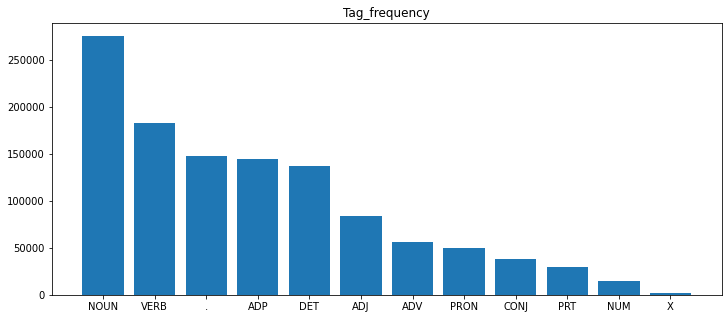

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

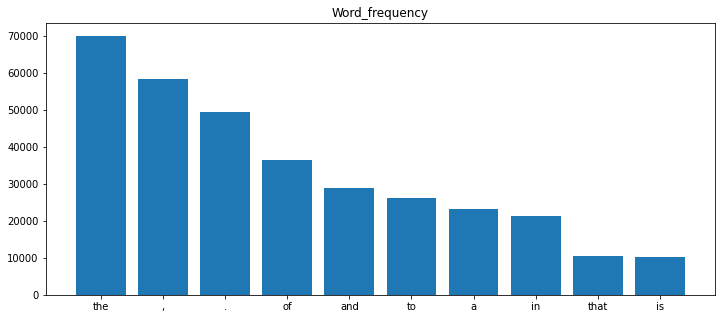

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [ ]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [ ]:
# most popular tag
tag_num.index[0]

'NOUN'

In [ ]:
words_with_most_popular_tag = [word for (word, tag) in brown_tagged_words if tag == tag_num.index[0]]
words_with_most_popular_tag_num = pd.Series(nltk.FreqDist(words_with_most_popular_tag)).sort_values(ascending=False)

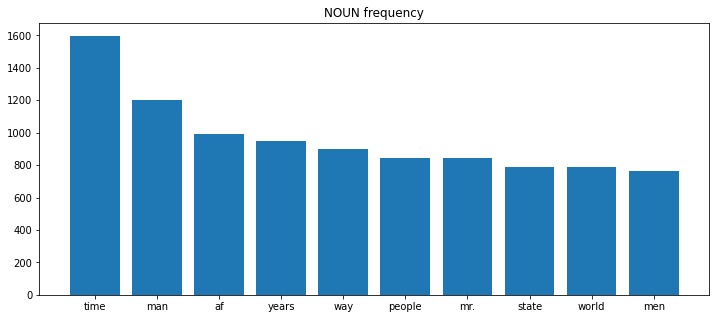

Most popular NOUN: time


In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(words_with_most_popular_tag_num.index[:10], words_with_most_popular_tag_num.values[:10])
plt.title(f"{tag_num.index[0]} frequency")
plt.show()
print(f'Most popular {tag_num.index[0]}:', words_with_most_popular_tag_num.index[0])

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
#brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')


# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype=object)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

In [ ]:
len(train_sents)

51606

In [ ]:
len(test_sents)

5734

### Experiments to understand the HMM fitting algo



In [ ]:
# tags sorted in alphabetical order
tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
tag_num

.       147565
ADJ      83721
ADP     144766
ADV      56239
CONJ     38151
DET     137019
NOUN    275558
NUM      14874
PRON     49334
PRT      29829
VERB    182750
X         1386
dtype: int64

In [ ]:
# Matrix A of state-transition probabilities
display(pd.DataFrame({f'{tag}' : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index))
print(pd.DataFrame({f'{tag}' : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index).shape)

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0,0,0,0,0,0,0,0,0,0,0,0
ADJ,0,0,0,0,0,0,0,0,0,0,0,0
ADP,0,0,0,0,0,0,0,0,0,0,0,0
ADV,0,0,0,0,0,0,0,0,0,0,0,0
CONJ,0,0,0,0,0,0,0,0,0,0,0,0
DET,0,0,0,0,0,0,0,0,0,0,0,0
NOUN,0,0,0,0,0,0,0,0,0,0,0,0
NUM,0,0,0,0,0,0,0,0,0,0,0,0
PRON,0,0,0,0,0,0,0,0,0,0,0,0
PRT,0,0,0,0,0,0,0,0,0,0,0,0


(12, 12)


In [ ]:
pd.DataFrame({f'{tag}' : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index).shape

(49815, 12)

In [ ]:
tag_num.sort_values(ascending=False).index[0]

'NOUN'

In [ ]:
mpt = tag_num.sort_values(ascending=False).index[0] # most popular tag
print('Most popular tag:', mpt)
words_with_most_popular_tag = [word for (word, tag) in brown_tagged_words if tag == mpt]
words_with_most_popular_tag_num = pd.Series(nltk.FreqDist(words_with_most_popular_tag)).sort_values(ascending=False)

Most popular tag: NOUN


In [ ]:
(words_with_most_popular_tag_num.index[0], mpt)

('time', 'NOUN')

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги (**S**tates)
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова (**O**bservations)
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) = \arg \max_{Y} p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n$$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
# importing copy module
import copy
  
# initializing list 1 
li1 = [1, 2, [3,5], 4]
  
  
# using copy for shallow copy  
li2 = copy.copy(li1) 
print(li2)

# using deepcopy for deepcopy  
li3 = copy.deepcopy(li1)
print(li3)

[1, 2, [3, 5], 4]
[1, 2, [3, 5], 4]


In [ ]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tagged_words = [(word, tag) for sent in train_tokens_tags_list
                                    for (word, tag) in sent]
        tags = [tag for sent in train_tokens_tags_list
                    for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                      for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

        self.tags = tag_num.index
        self.words = word_num.index

        mpv = self.words[0] # most popular word
        mpt = self.tags[0]  # most popular tag
        # words with most popular tag
        words_with_most_popular_tag = [word for (word, tag) in tagged_words if tag == mpt]
        # most popular word
        mpwmpt = pd.Series(nltk.FreqDist(words_with_most_popular_tag)).sort_values(ascending=False).index[0]            

        self.most_popular_tag = mpt
        self.most_popular_word = mpv
        self.most_popular_word_from_most_popular_tag = mpwmpt
        assert self.most_popular_word_from_most_popular_tag in self.words
        

        # A: state-transition probabilities p(y_t|y_{t-1})  shape: [|tag_num|, |tag_num|]
        A = pd.DataFrame({f'{tag}' : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        # B: emission probabilities p(x_t|y_t)              shape: [|word_num|, |tag_num|]
        B = pd.DataFrame({f'{tag}' : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов

        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0) # shape: [|tag_num|, |tag_num|]
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)           # shape: [|word_num|, |tag_num|]
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = [np.array([]) for i in range(len(test_tokens_list))]
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = [] # текущее предложение
            len_sent = len(test_tokens_list[i_sent]) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                
                current_word = test_tokens_list[i_sent][t]
                if current_word in self.words:
                    current_sent.append(current_word)
                else:
                    current_sent.append(self.most_popular_word_from_most_popular_tag)
                
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    # print(current_sent[t], s)
                    try:
                        q[t + 1][i_s] = np.max(q[t] *
                            self.A.loc[:, s] * 
                            self.B.loc[current_sent[t], s])
                    except KeyError as e:
                        print(e)
                        print('Current tag s:', s)
                        print('Curent token:', current_sent[t])
                        print('Curent token is known:', current_sent[t] in self.words)
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

In [ ]:
my_model.most_popular_word

'the'

In [ ]:
my_model.most_popular_tag

'NOUN'

In [ ]:
my_model.most_popular_word_from_most_popular_tag

'time'

In [ ]:
my_model.most_popular_word_from_most_popular_tag in my_model.words

True

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'],
         ['a', 'cat', 'and', 'a', 'dog'],
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
preds = my_model.predict(sents)
preds

[array(['NOUN', 'VERB', 'VERB'], dtype='<U4'),
 array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4'),
 array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4'),
 array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4')]

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [ ]:
preds[0][1]

'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [ ]:
preds[3][1] # wrong unswer (we have not seen 'favourite' before, was substituted by 'time')

'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for i, sent in enumerate(sents):
        tags = np.array([tag for (word, tag) in sent])

        # extra brackets to show that this is a text with 1 sentence
        words = np.array([[word for (word, tag) in sent]])
        preds = np.array(model.predict(words)[0])

        match = (preds == tags)
        #print(match)

        true_pred += match.sum()
        num_pred += len(preds)

    acc = true_pred / num_pred
    print("Accuracy:", acc * 100, '%')
    return acc

In [ ]:
my_model.most_popular_word_from_most_popular_tag in my_model.words

True

In [ ]:
acc_score = accuracy_score(my_model, test_sents)

Accuracy: 96.26470820500671 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
np.round(acc_score, 1)

1.0

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

def default_accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = np.array([tag for (word, tag) in sent])

        words = [word for (word, tag) in sent]
        words_and_preds = model.tag(words)
        preds = np.array([pred for (word, pred) in words_and_preds])

        match = (tags == preds)
        #print(match)

        true_pred += match.sum()
        num_pred += len(preds)

    acc = true_pred / num_pred
    print("Accuracy:", acc * 100, '%')
    return acc

In [ ]:
default_acc_score = default_accuracy_score(default_tagger, test_sents)

Accuracy: 23.47521651004238 %


In [ ]:
np.round(default_acc_score, 1)

0.2

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
from nltk.tag.mapping import map_tag

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
bj_sent = ['passangers', 'enjoy', 'their', 'ride', 'on', 'a', 'wonedful', 'bus']
nltk.pos_tag(bj_sent, tagset='universal')

[('passangers', 'NOUN'),
 ('enjoy', 'VERB'),
 ('their', 'PRON'),
 ('ride', 'NOUN'),
 ('on', 'ADP'),
 ('a', 'DET'),
 ('wonedful', 'ADJ'),
 ('bus', 'NOUN')]

In [ ]:
def nltk_accuracy_score(tagset, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = np.array([tag for (word, tag) in sent])

        words = [word for (word, tag) in sent]
        words_and_preds = nltk.pos_tag(words, tagset=tagset)
        preds = np.array([pred for (word, pred) in words_and_preds])

        match = (tags == preds)
        #print(match)

        true_pred += match.sum()
        num_pred += len(preds)

    acc = true_pred / num_pred
    print("Accuracy:", np.round(acc * 100, 1), '%')
    return acc

In [ ]:
nltk_acc_score = nltk_accuracy_score('universal', test_sents)
nltk_acc_score

Accuracy: 90.7 %


0.9069730711521756

https://github.com/IlyaGusev/rnnmorph

In [ ]:
!pip install rnnmorph
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

     |████████████████████████████████| 10.5MB 11.3MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 8.2MB 39.2MB/s 
  Created wheel for rnnmorph: filename=rnnmorph-0.4.0-cp37-none-any.whl size=10521037 sha256=0b5073f9f49a129cb2f0c15ffac7868be007ad4447553297bef7bd007b2b2cf8
  Stored in directory: /root/.cache/pip/wheels/61/74/5d/3c6c523a759b67e6a81677e2aad003321536587d1575a4face
  Created wheel for russian-tagsets: filename=russian_tagsets-0.6-cp37-none-any.whl size=24635 sha256=6d8fce819b6d60795a8e787d4b0e366ea3a9a9dcb0b3cf9dd9845e68af0dcba7
  Stored in directory: /root/.cache/pip/wheels/e8/9d/dd/4679aca4031fdb0d3ad65e165ba5343e61441ed7ad587a08e6
Successfully built rnnmorph russian-tagsets
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagg

In [ ]:
res = predictor.predict(bj_sent)
POSs = [res[i].pos for i in range(len(res))]
POSs

['NOUN', 'VERB', 'PRON', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN']

In [ ]:
def rnnmorph_accuracy_score(sents):
    true_pred = 0
    num_pred = 0

    for i, sent in enumerate(sents):
        tags = np.array([tag for (word, tag) in sent])
        words = [word for (word, tag) in sent]
        full_preds = predictor.predict(words)
        preds = np.array([full_preds[i].pos for i in range(len(full_preds))])

        match = (tags == preds)
        #print(match)

        true_pred += match.sum()
        num_pred += len(preds)

        # for debugging
        # if i == 2:
        #     break

    acc = true_pred / num_pred
    print("Accuracy:", np.round(acc * 100, 1), '%')
    return acc

In [ ]:
rnnmorph_acc_score = rnnmorph_accuracy_score(test_sents)
rnnmorph_acc_score

Accuracy: 67.0 %


0.6700711609500996

### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [ ]:
print("nltk_acc_score    :", nltk_acc_score.round(3))
print("rnnmorph_acc_score:", rnnmorph_acc_score.round(3))

nltk_acc_score    : 0.907
rnnmorph_acc_score: 0.67


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

[`(word1, tag1)`, `(word2, tag2)`, `(word3, tag3)`] $\to$
[`(word1, word2, word3)`, `(tag1, tag2, tag3)`]

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
pos_data[0]

[('The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'),
 ('DET',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'NOUN',
  'DET',
  'NOUN',
  'ADP',
  'NOUN',
  'ADJ',
  'NOUN',
  'NOUN',
  'VERB',
  '.',
  'DET',
  'NOUN',
  '.',
  'ADP',
  'DET',
  'NOUN',
  'VERB',
  'NOUN',
  '.')]

До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)],
                                                           fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=10)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (words) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (tags) vocabulary: {len(TAG.vocab)}")

print('\nExamples of words:')
print('\t', WORD.vocab.itos[::100])

print('\nExamples of POS tags:')
print('\t', TAG.vocab.itos)

Unique tokens in source (words) vocabulary: 7331
Unique tokens in target (tags) vocabulary: 13

Examples of words:
	 ['<unk>', 'did', 'away', 'means', 'force', 'dr.', 'industry', 'hair', 'try', 'larger', 'write', 'facilities', 'units', 'indicate', 'difficulty', 'hearing', 'greatly', 'reference', 'belief', 'cousin', 'appearance', 'introduced', 'destroy', 'expansion', 'anyway', 'operator', 'combined', 'palace', 'steady', 'worst', 'vice', 'unfortunately', 'articles', '**zg', 'vehicle', 'representing', 'panel', 'locking', 'crowded', '29', 'parade', 'craft', 'ward', 'loaded', 'autonomy', 'loud', 'balanced', 'passages', 'affects', 'hotels', 'sketches', "children's", 'mathematics', 'supervision', 'compounds', 'lodge', 'sums', 'checks', 'guessed', 'prescribed', 'annually', 'durable', 'neglect', 'stalin', 'breeze', 'entertained', 'manners', 'sadly', '72', 'congressmen', 'grin', 'mm.', 'richards', 'twins']

Examples of POS tags:
	 ['<pad>', 'NOUN', 'VERB', '.', 'ADP', 'DET', 'ADJ', 'ADV', 'PRON'

In [ ]:
print(vars(train_data.examples[9]))

{'words': ['although', 'not', 'much', 'desiring', 'the', 'account', ',', 'he', 'had', 'been', 'appointed', 'advertising', 'head', 'of', 'zenith', '.'], 'tags': ['ADP', 'ADV', 'ADV', 'VERB', 'DET', 'NOUN', '.', 'PRON', 'VERB', 'VERB', 'VERB', 'VERB', 'NOUN', 'ADP', 'NOUN', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

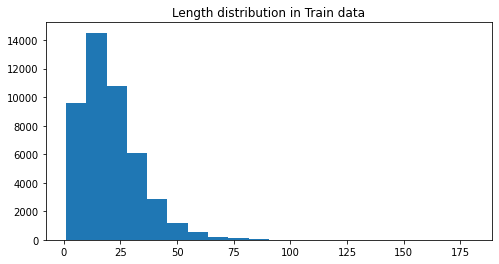

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

In [ ]:
for batch in train_iterator:
    print(batch, '\n') # to check which attirbutes there are there in the batch

    print(batch.words.shape)
    print(batch.tags.shape)
    break


[torchtext.legacy.data.batch.Batch of size 32]
	[.words]:[torch.cuda.LongTensor of size 53x32 (GPU 0)]
	[.tags]:[torch.cuda.LongTensor of size 53x32 (GPU 0)] 

torch.Size([53, 32])
torch.Size([53, 32])


### Модель и её обучение

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, dropout, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim,
                           num_layers=num_layers,
                           dropout=dropout, bidirectional=bidirectional)
        # if bidirectional, predict based on concatenation of 2 hidden layers
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.embeddings(sent)

        output, _ = self.rnn(self.dropout(embedded))
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab) # size of the dictionary of embeddings
OUTPUT_DIM = len(TAG.vocab) # number of possible outputs (tags)
EMB_DIM = 300               # for Embedding: the size of each embedding vector;
                            # for LSTM: The number of expected features in the input x
HID_DIM = 16                # The number of features in the hidden state h
LSTM_LAYERS = 2             # Number of recurrent layers. E.g., setting num_layers=2 
                            # would mean stacking two LSTMs together to form a stacked LSTM,
                            # with the second LSTM taking in outputs of the first LSTM and
                            # computing the final results. Default: 1
DROPOUT = 0.2               # both for LSTM layer and between self.embeddings and self.rnn
BIDIRECTIONAL = True        # make LSTM biderectional or not

model = LSTMTagger(input_dim=INPUT_DIM, emb_dim=EMB_DIM,
                   hid_dim=HID_DIM, output_dim=OUTPUT_DIM,
                   num_layers=LSTM_LAYERS,
                   dropout=DROPOUT, bidirectional=BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(7331, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(300, 16, num_layers=2, dropout=0.2, bidirectional=True)
  (tag): Linear(in_features=32, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model, trainable=False):
    if trainable:
        pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        pytorch_total_params = sum(p.numel() for p in model.parameters())
    
    return pytorch_total_params

print(f'The model has {count_parameters(model, trainable=True):,} trainable parameters')

The model has 2,246,833 trainable parameters


Погнали обучать

In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        # split the batch into inputs and labels
        words = batch.words.to(device)
        tags  = batch.tags.to(device)
        
        optimizer.zero_grad()
        
        # forward
        output = model(words)
        
        # Transform true tags and outputs from one format:
        #
        # tags = [sent len, batch size]
        # output = [sent len, batch size, output dim]
        #
        # to another:
        #
        # tags = [sent len * batch size]
        # output = [sent len * batch size, output dim]
        tags = tags.view(-1)
        output = output.view(-1, output.shape[2])
        
        # backward
        loss = criterion(output, tags)
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        # optimize
        optimizer.step()
        

        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            # split the batch into inputs and labels
            words = batch.words.to(device)
            tags  = batch.tags.to(device)
                        
            # forward
            output = model(words)
            
            # Transform true tags and outputs from one format:
            #
            # tags = [sent len, batch size]
            # output = [sent len, batch size, output dim]
            #
            # to another:
            #
            # tags = [sent len * batch size]
            # output = [sent len * batch size, output dim]
            tags = tags.view(-1)
            output = output.view(-1, output.shape[2])

            loss = criterion(output, tags)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

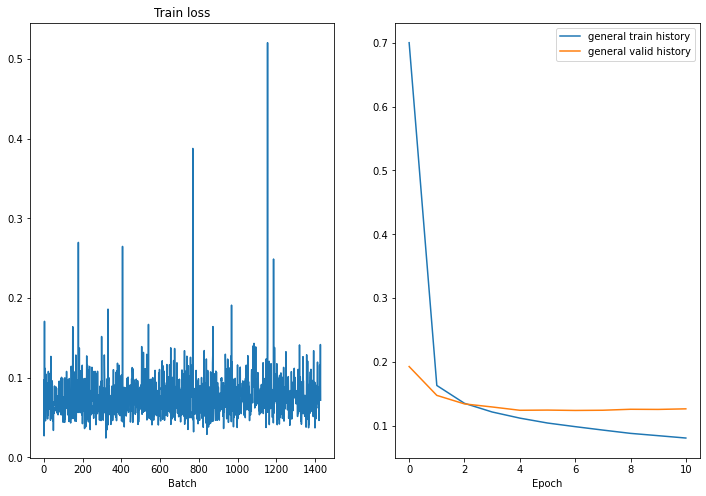

Reached maximum patience of 5.
No improvement in loss for 5 epochs


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 100
CLIP = 1
PATIENCE = 5

current_patience = 0
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        current_patience = 0 # reset patience since we just had an improvement
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    else:
        current_patience += 1
        if current_patience >= PATIENCE:
            print(f'Reached maximum patience of {PATIENCE}.')
            print(f'No improvement in loss for {PATIENCE} epochs')
            break

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [ ]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            # split the batch into inputs and labels
            words = batch.words.to(device)
            tags  = batch.tags.to(device)
                        
            # forward
            #output = [sent len, batch size, output dim]
            output = model(words)
            
            # Take argmax across the ouutput dimention to determine the predicted tag (class)
            #output = [sent len, batch size]
            output = torch.argmax(output, dim=2)
            
            # put on the cpu and convert to numpy
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [ ]:
print("Accuracy:", accuracy_model(model, valid_iterator), '%')

Accuracy: 95.959 %


In [ ]:
# DO NOT OVERFIT ON TEST SET! RUN ONLY WHEN HAPPY WITH VALIDAITON ACCURACY!
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 95.949 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [ ]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, LSTM_LAYERS, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Пример решение нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     ADJ
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

### Humor

#### HMM

Stage    | Time (s) | Accuracy
---------|----------|---------
Training | 11       | N/A
Inference| 57       | 88.8

#### BiLSTMTagger

Stage    | Time (s) | Accuracy
---------|----------|---------
Training | 154      | 84.8 (Val)
Inference| 149      | 86.0 (Test)

- HMM is faster both during training and inference.
- HMM also has better accuracy.

### Full Dataset

#### HMM

Stage    | Time (s) | Accuracy
---------|----------|---------
Training |  538     | N/A
Inference| 3582     | 96.2

#### BiLSTMTagger

Stage    | Time (s) | Accuracy
---------|----------|---------
Training | 1515     | 96.0 (Val)
Inference| 1510     | 95.9 (Test)

- HMM is faster during trainning, but slower on inference.
- BiLSTMTagger shows similar accuracy score with more data used for training.
- Both models improved the accuracy when gicen access to more data.
- If inference time is important, using BiLSTMTagger is preferable.

